In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
import random
from random import random as rand

from tqdm import tqdm

import pingouin as pg

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
subj_list = ['03','04','05','06','07',
             '08','09','10','11','12',
             '14','15','16','17','18',
             '19','20','21','22','24',
             '25','26','27','29']

In [4]:
today = date.today().strftime("%Y%m%d")
dir_root = '/home/sungbeenpark/Github/labs/GL'
dir_behav = join(dir_root, 'behav_data')
dir_result = join(dir_root, 'results')
dir_script = join(dir_root, 'scripts')
dir_output = dir_script

In [5]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
sec_per_trial = 4  ## time spend(second) in each trial
ntrial = 12 ## the number of trials per block
nblock = 12 ## the number of blocks per RUN
nblocks_main = nblock*4 # total number of blocks = 12 blocks/run * 4 runs
nblocks_test = nblock*2 # total number of blocks = 12 blocks/run * 4 runs

In [6]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [7]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [8]:
def calc_mrew(behav_datum):
    datum = scipy.io.loadmat(behav_datum)
    nS = int(datum['nSampleTrial'][0][0])    # 4 s * 60 Hz = 240 samples
    tpr = int(datum['nTrialperRun'][0][0])   # 1 + 12 trials/block * 12 blocks
    nrun = int(datum['nRun'][0][0])

    temp = datum['LearnTrialStartTime'][0]
    idx_editpoint = [i+1 for i,t in enumerate(temp[:-2]) if (temp[i]>temp[i+1])]

    ## counting how many times did they hit the target
    cnt_hit_all = np.zeros((tpr*nrun,nS), dtype=bool)
    for t,ID in enumerate(datum['targetID'][0][idx_editpoint[0]:]):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*t:nS*(t+1)] # allXY.shape = (2, 60 Hz * 4 s/trial * 145 trials/run * 6 runs = 208800 frames)
        err = xy - np.ones((2,nS))*pos.T     # err.shape = (2, nS)
        cnt_hit_all[t,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)
        
        disp = datum['allData'][:,nS*t:nS*(t+1)] # allData.shape = (14, 208800)

    rew_bin = np.zeros((nrun,sec_per_trial*tpr))
    for r in range(nrun):
        temp = cnt_hit_all[tpr*r:tpr*(r+1),:].reshape(nS*tpr,1)
        for i in range(sec_per_trial*tpr):
            rew_bin[r,i] = sum(temp[60*i:60*(i+1)])

    max_score =  nS*ntrial   ## total frames in a block
    temp = rew_bin[:,sec_per_trial:].reshape(nrun*sec_per_trial*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[sec_per_trial*ntrial*i:sec_per_trial*ntrial*(i+1)])/max_score

    return norm_mrew, cnt_hit_all

---

In [9]:
subj = 'GL03'
behav_datum = join(dir_behav, '%s-fmri.mat'%subj)
datum = scipy.io.loadmat(behav_datum)

In [9]:
datum['allData'].shape

(14, 243360)

In [10]:
243360-208800

34560

In [11]:
datum['allXY'].shape

(2, 208800)

<AxesSubplot:>

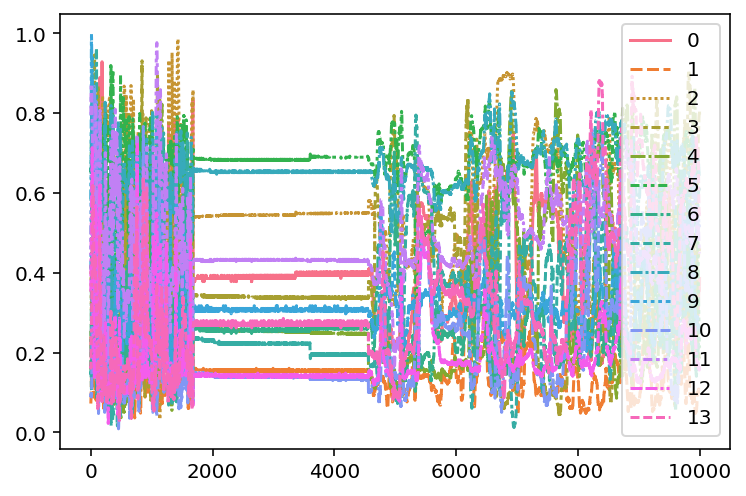

In [12]:
sns.lineplot(data=datum['allData'][:,30000:40000].transpose())

In [13]:
n, c = calc_mrew(behav_datum)

<AxesSubplot:>

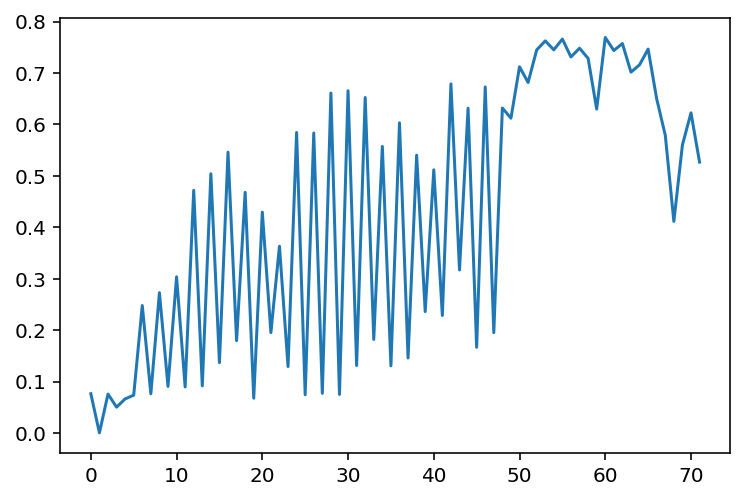

In [20]:
sns.lineplot(data=n)

# Success rate

In [9]:
rew = {}
for nn in tqdm(subj_list):
    subj = 'GL' + nn
    behav_datum = dir_behav + '/%s-fmri.mat' %subj
    rew[subj], _ = calc_mrew(behav_datum)
    
df = pd.DataFrame.from_dict(rew, orient='index', dtype=float)

100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


Text(0.5, 0, 'blocks')

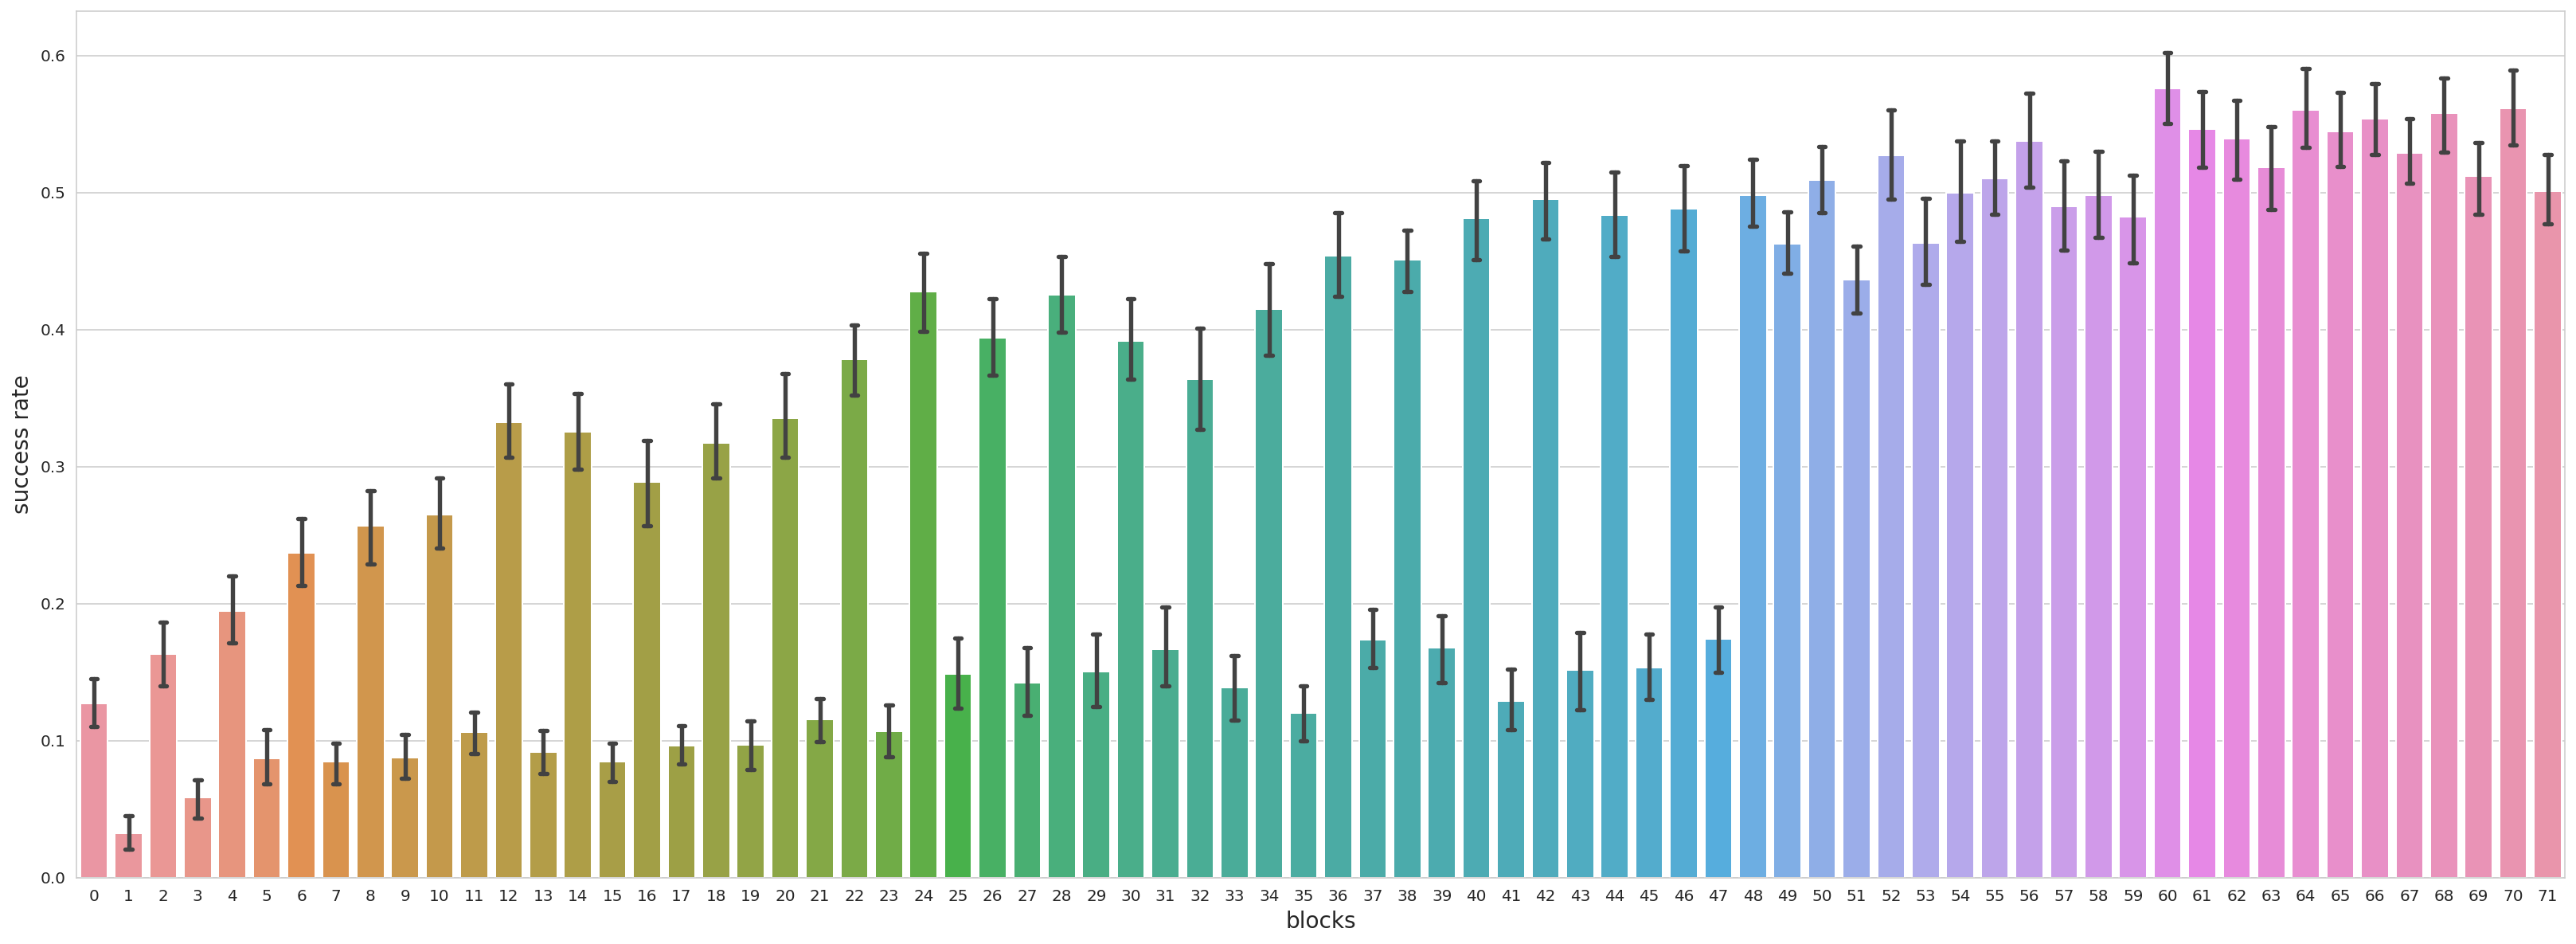

In [12]:
# plt.figure(figsize=(28, 10))
# sns.set_style('whitegrid')
# sns.barplot(data=df[range(72)], ci=100*sigma_1, capsize=.2)
# plt.ylabel('success rate', size=14)
# plt.xlabel('blocks', size=14)

In [10]:
df_long = pd.melt(
    df.reset_index()
    , id_vars=['index']
    , var_name='block', value_name='success_rate'
)
df_long['condition'] = ['FB' if (block<nblocks_main)&(block%2==0) else ('nFB' if (block<nblocks_main)&(block%2==1) else 'Test') for block in df_long.block]
df_long['run'] = [(block//nblock + 1) for block in df_long.block]
df_long['stage'] = ['early' if run in [1,2] else ('late' if run in [3,4,5,6] else 'invalid') for run in df_long.run]
df_long.rename(columns = {'index':'subj'}, inplace = True)
df_long

,subj,block,success_rate,condition,run,stage
0,GL03,0,0.076389,FB,1,early
1,GL04,0,0.287153,FB,1,early
2,GL05,0,0.092708,FB,1,early
3,GL06,0,0.029167,FB,1,early
4,GL07,0,0.128819,FB,1,early
...,...,...,...,...,...,...
1723,GL24,71,0.513889,Test,6,late
1724,GL25,71,0.684375,Test,6,late
1725,GL26,71,0.362153,Test,6,late
1726,GL27,71,0.682639,Test,6,late


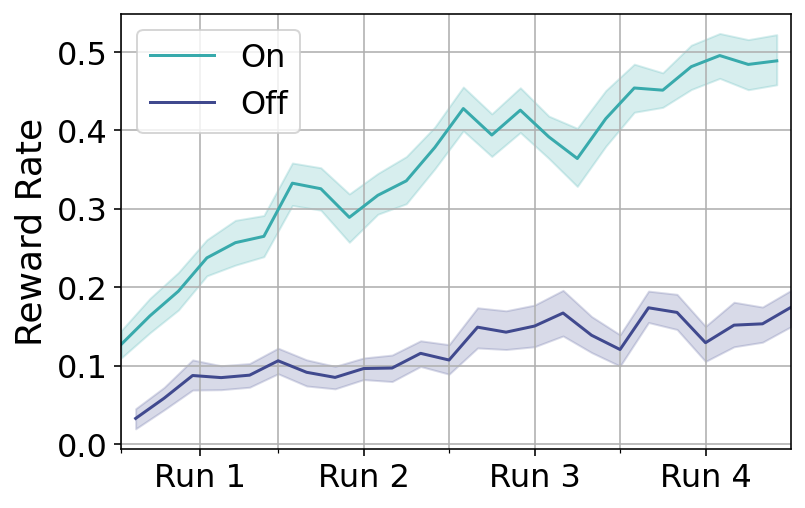

In [25]:
# minor = [0, 11, 23, 35, 47]
# major = [0.5*(minor[i+1]+minor[i]) for i in range(len(minor)-1)]

# ax = sns.lineplot(
#     data=df_long[df_long.condition!='Test'], x='block', y='success_rate'
#     , hue='condition', style='condition'
#     , ci=68, err_style='band', markers=False, dashes=False
#     , palette=sns.color_palette("mako_r", 2)
# )
# ax.set(xlim=(0,47))
# ax.set_xlabel(None)
# ax.set_xticks(minor[:4], minor=True)
# ax.set_xticks(major, minor=False)
# ax.set_xticklabels(['Run 1', 'Run 2', 'Run 3', 'Run 4'], minor=False)
# ax.grid(None)
# ax.grid(axis='x', which='minor')
# for text, new in zip(ax.legend(fontsize=16).texts, ['On', 'Off']):
#     text.set_text(new)
# ax.set_ylabel('Reward Rate', fontsize=18)
# ax.tick_params(axis='both', which='major', labelsize=16)

In [13]:
palette = sns.color_palette("nipy_spectral", 3)
palette

[(0.0, 0.46931372549019607, 0.8667),
 (0.0, 0.7385313725490196, 0.0),
 (1.0, 0.7882352941176471, 0.0)]

/tmp/ipykernel_888017/429964254.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



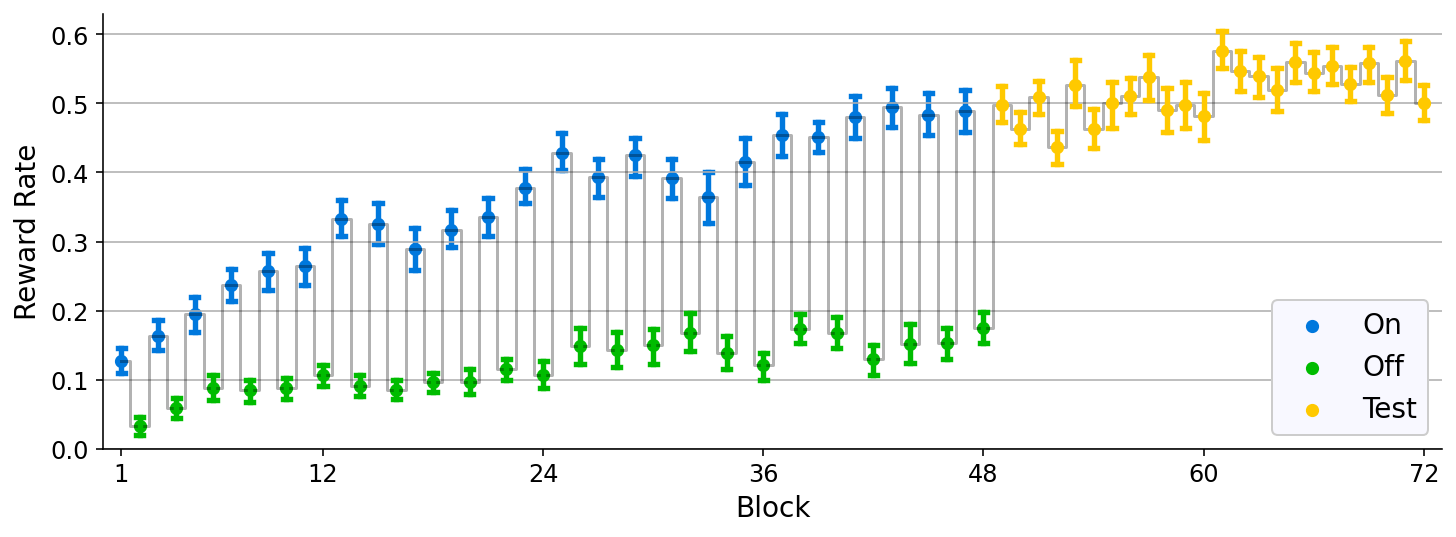

In [14]:
fig, ax = plt.subplots(figsize=(12,4))

## step line
ax = sns.lineplot(
    data=df_long
    , x="block", y="success_rate"
    , color='k', drawstyle='steps-mid', alpha=0.3
    , ci=None
    , legend=False
    , ax=ax
)

ax = sns.pointplot(
    data=df_long
    , x="block", y="success_rate", hue="condition"
    , join=False, palette=palette
    , markers='o', scale=.75
    , ci=68, capsize=0.4
    , ax=ax
)
ax.set(ylim=(0,0.63), xlim=(-1,72))
ax.set_xticks([0,11,23,35,47,59,71], minor=False)
ax.grid(axis='y')
ax.set_xticklabels(ax.get_xticks()+1, fontsize=12)
ax.set_yticklabels(['%.1f'%y for y in ax.get_yticks()], fontsize=12)
ax.set_ylabel('Reward Rate', fontsize=14)
ax.set_xlabel('Block', fontsize=14)
ax.legend(
    ax.get_legend_handles_labels()[0], ['On', 'Off', 'Test']
    , loc='lower right'
    , fontsize=14
    , facecolor='ghostwhite', framealpha=1
)

# ## individual points
# sns.stripplot(
#     data=df_long
#     , x="block", y="success_rate", hue="condition"
# )

# palette = sns.color_palette("gist_yarg_r", 3)
# ## A shade for FB
# ax.bar(
#     x=np.arange(0,47,2)
#     , height=1, width=1
#     , align='center'
#     , color=palette[0], alpha=0.2, edgecolor=None
# )

# ## A shade for nFB
# ax.bar(
#     x=np.arange(0,47,2)+1
#     , height=1, width=1
#     , align='center'
#     , color=palette[1], alpha=0.2, edgecolor=None
# )

# ## A shade for Test
# ax.bar(
#     x=np.arange(48,72)
#     , height=1, width=1
#     , align='center'
#     , color=palette[2], alpha=0.2, edgecolor=None
# )

sns.despine(bottom=False, left=False)

fig.savefig(
    join(dir_result, 'GL.behav.reward_rate.by_conditions.png')
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

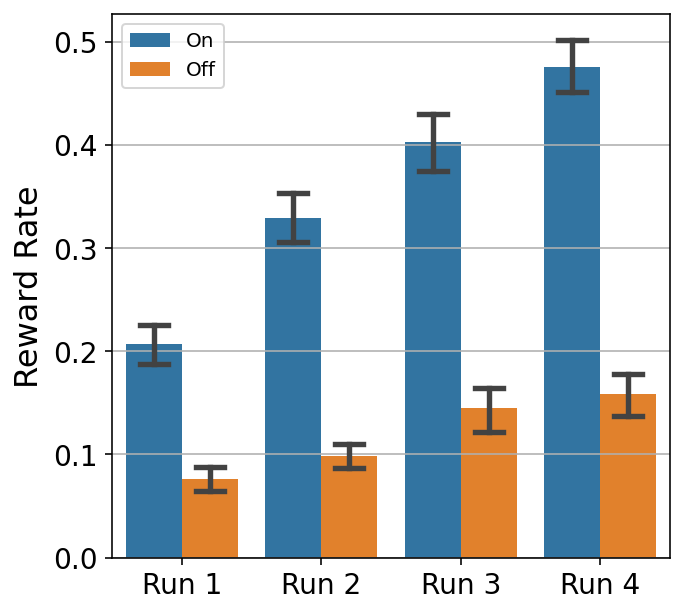

In [29]:
fig, ax = plt.subplots(figsize=(5,5))

tmp = df_long.groupby(['subj', 'condition', 'stage', 'run'], as_index=False).mean()
data = tmp[tmp.condition!='Test']

ax = sns.barplot(
    data=data
    , x='run', y='success_rate', hue='condition'
    , ci=68, capsize=0.2
    , ax=ax
)
ax.legend(loc='best')
ax.grid(axis='y')
legend = ['On', 'Off']
for text, new in zip(ax.legend().texts, legend):
    text.set_text(new)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(['Run 1','Run 2','Run 3','Run 4'])
ax.set_ylabel('Reward Rate', fontsize=16)

fig.savefig(
    join(dir_result, 'GL.behav.reward_rate.by_runs.png')
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

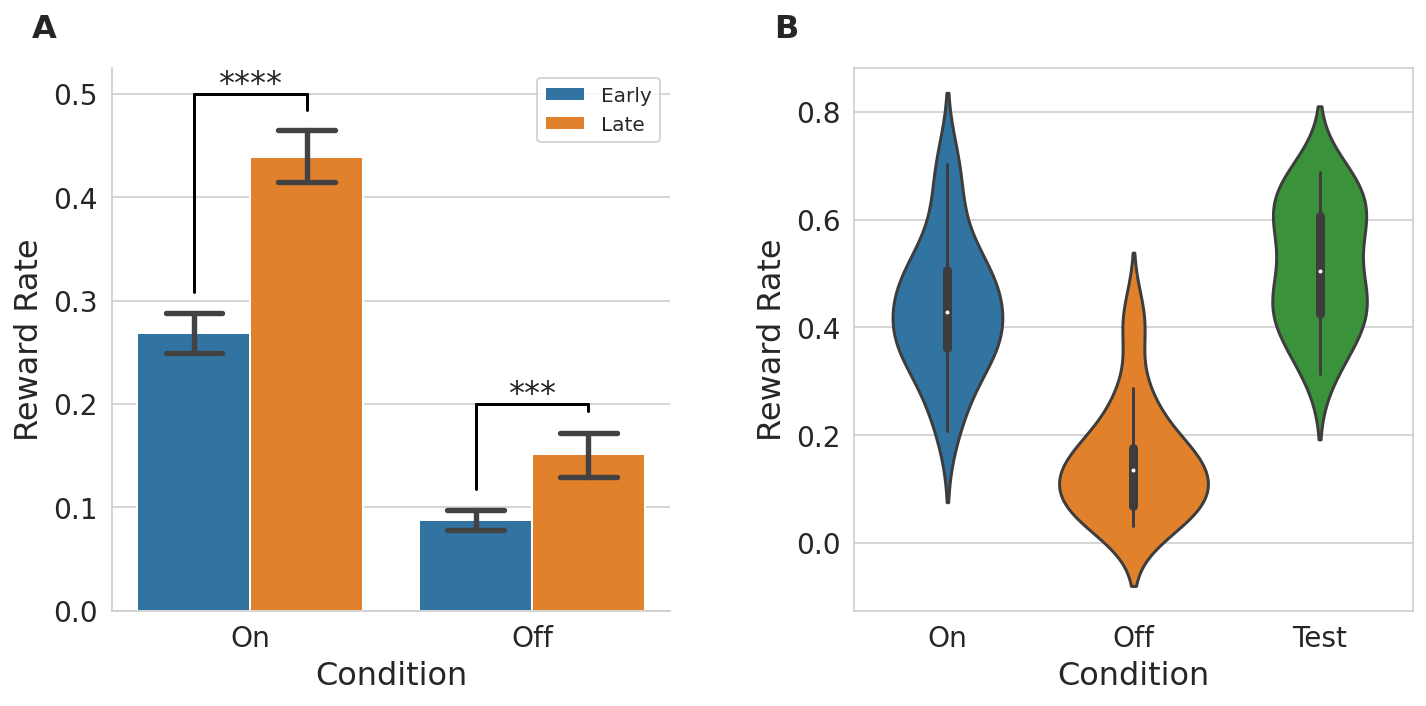

In [12]:
ncols, nrows = 2, 1

loc_figlabels = (-0.1, 1.1)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,5*nrows))

tmp = df_long.groupby(['subj', 'condition', 'stage'], as_index=False).mean()
data = tmp[tmp.condition!='Test']

ax = axs[0]
ax = sns.barplot(
    data=data
    , x='condition', y='success_rate', hue='stage'
    , ci=68, capsize=0.2
    , ax=ax
)
ax.legend(loc='best')
legend = ['Early', 'Late']
for text, new in zip(ax.legend().texts, legend):
    text.set_text(new)
ax.set_xlabel('Condition', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(['On', 'Off'])
ax.set_ylabel('Reward Rate', fontsize=16)

## paired t-test
### feedback
a = data[(data.stage=='early')&(data.condition=='FB')].success_rate
b = data[(data.stage=='late')&(data.condition=='FB')].success_rate
tval, pval = stats.ttest_rel(a,b)
x0 = 0
h = 0.5
ax.plot([x0-0.2,x0-0.2],[a.mean()+a.sem()+0.02,h], 'k-')
ax.plot([x0+0.2,x0+0.2],[b.mean()+b.sem()+0.02,h], 'k-')
ax.plot([x0-0.2,x0+0.2],[h,h], 'k-')
ax.text(
    0.5*(x0+x0), h+0.01
    , convert_pvalue_to_asterisks(pval), fontsize=16
    , va='center', ha='center'
)
### non feedback
a = data[(data.stage=='early')&(data.condition=='nFB')].success_rate
b = data[(data.stage=='late')&(data.condition=='nFB')].success_rate
tval, pval = stats.ttest_rel(a,b)
x0 = 1
h = 0.2
ax.plot([x0-0.2,x0-0.2],[a.mean()+a.sem()+0.02,h], 'k-')
ax.plot([x0+0.2,x0+0.2],[b.mean()+b.sem()+0.02,h], 'k-')
ax.plot([x0-0.2,x0+0.2],[h,h], 'k-')
ax.text(
    0.5*(x0+x0), h+0.01
    , convert_pvalue_to_asterisks(pval), fontsize=16
    , va='center', ha='center'
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.text(
    *loc_figlabels, 'A'
    , transform=ax.transAxes
    , fontsize=16, fontweight='bold', va='top', ha='right'
)

## ========================================== ##
ax = axs[1]

data = tmp[tmp.stage=='late']

ax = sns.violinplot(
    data=data, x='condition', y='success_rate'
    , order=['FB', 'nFB', 'Test']
    , ci=68, capsize=.2
    , ax=ax
)
ax.set_xlabel('Condition', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(['On', 'Off', 'Test'])
ax.set_ylabel('Reward Rate', fontsize=16)

plt.text(
    *loc_figlabels, 'B'
    , transform=ax.transAxes
    , fontsize=16, fontweight='bold', va='top', ha='right'
)

fig.tight_layout(w_pad=-25)

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GL/results/GL.behav.reward_rate.by_conditions.png'
#     , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

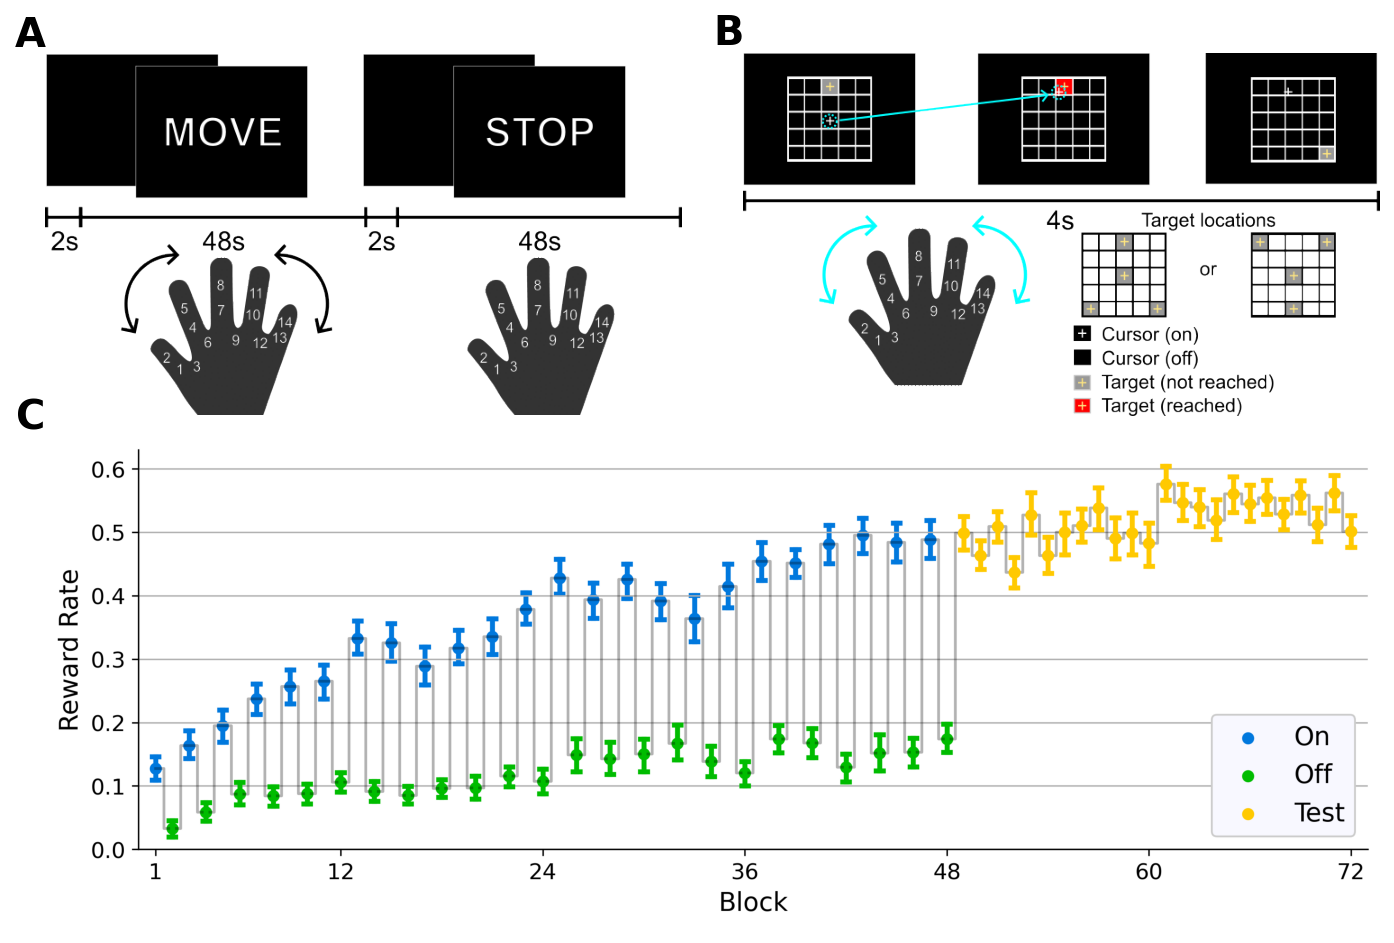

In [17]:
nrows, ncols = 2, 2
fig = plt.figure(figsize=(5*ncols,5*nrows))
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1]))
axs.append(fig.add_subplot(gs[1,0:2]))

loc_figlabels = np.array([0, 1.1])
labelsize = 20

axs[0].text(
    *loc_figlabels, 'A'
    , fontsize=labelsize, fontweight='bold', va='bottom', ha='right'
)
axs[1].text(
    *loc_figlabels, 'B'
    , fontsize=labelsize, fontweight='bold', va='bottom', ha='right'
)
axs[2].text(
    *loc_figlabels, 'C'
    , fontsize=labelsize, fontweight='bold', va='bottom', ha='right'
)
## ===================================================== ##
fig.tight_layout(w_pad=0, h_pad=-25)

## ===================================================== ##
ax = axs[0]
ax.imshow(
    mpimg.imread(join(dir_result, 'fig1_move_stop.png'))
)
ax.grid(None)
ax.axis('off')

## ===================================================== ##
ax = axs[1]
ax.imshow(
    mpimg.imread(join(dir_result, 'fig1_main.png'))
)
ax.grid(None)
ax.axis('off')

## ===================================================== ##
ax = axs[2]
ax.imshow(
    mpimg.imread(join(dir_result, 'GL.behav.reward_rate.by_conditions.png'))
)

## ===================================================== ##
ax.grid(None)
ax.axis('off')

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/GL.behav.reward_rate.by_conditions.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

# two-way repeated measures ANOVA
pg.rm_anova(
    data=df_long[df_long.condition!='Test']
    , dv='success_rate'
    , subject='subj'
    , within=['stage', 'condition']
    , correction=True
)

In [32]:
### paired t-test
dt = pg.pairwise_tests(
    data=df_long[df_long.condition!='Test']
    , dv= 'success_rate'
    , subject='subj'
    , within=['condition', 'stage']
    , alpha=0.05
    , effsize='eta-square'
)
dt

,Contrast,condition,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,eta-square
0,condition,-,FB,nFB,True,True,15.069654,23.0,two-sided,2.076039e-13,3.322e+10,0.621722
1,stage,-,early,late,True,True,-8.424813,23.0,two-sided,1.745555e-08,7.635e+05,0.299233
2,condition * stage,FB,early,late,True,True,-11.273382,23.0,two-sided,7.607422e-11,1.25e+08,0.366574
3,condition * stage,nFB,early,late,True,True,-4.369128,23.0,two-sided,2.243602e-04,131.408,0.131352


---

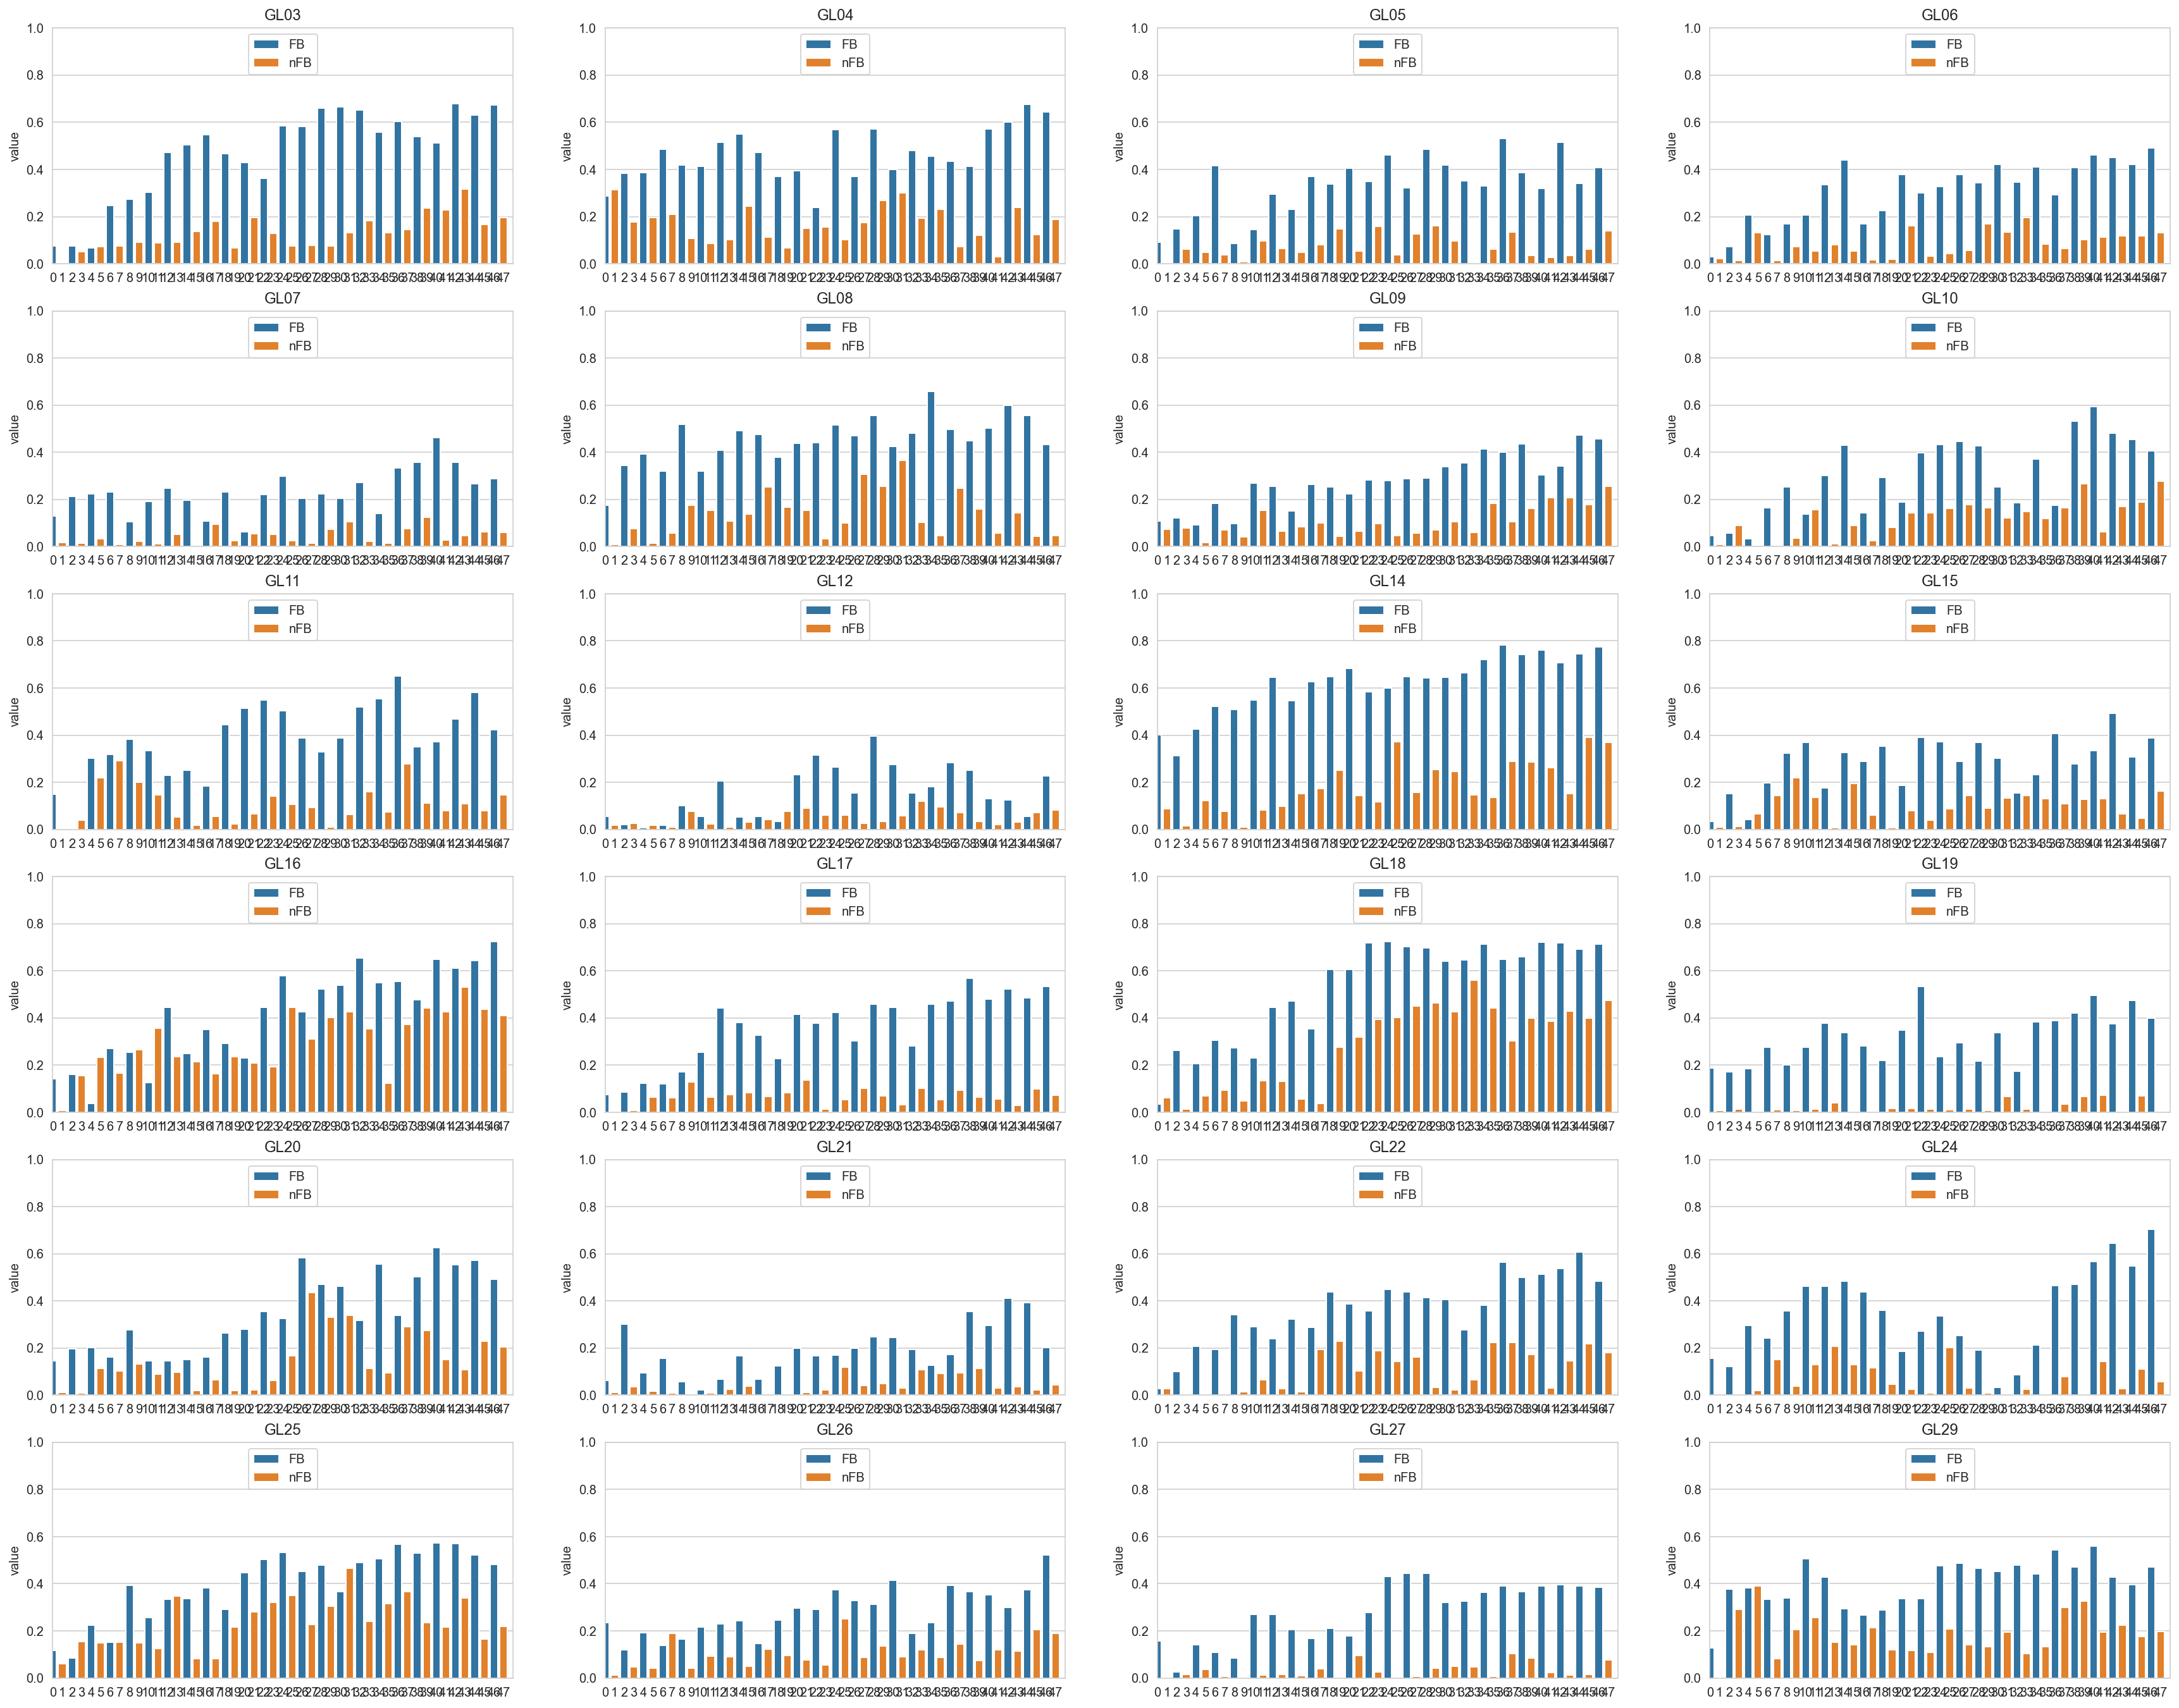

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 24)
sns.set_style('whitegrid')
for i, nn in enumerate(subj_list):
    subj = 'GL' + nn
    plt.subplot(6, 4, i+1)
#     sns.scatterplot(data=df.loc[subj][:tt])
#     sns.barplot(x=np.arange(32), y=df.loc[subj][np.arange(32)])
    sns.barplot(x='variable', y='value', data=df_long[df_long['index']==subj], hue='hue', dodge=False)
    plt.title(subj)
    plt.ylim(0, 1)
    plt.xlim(0, tt)
    plt.xlabel(None)
    plt.legend()

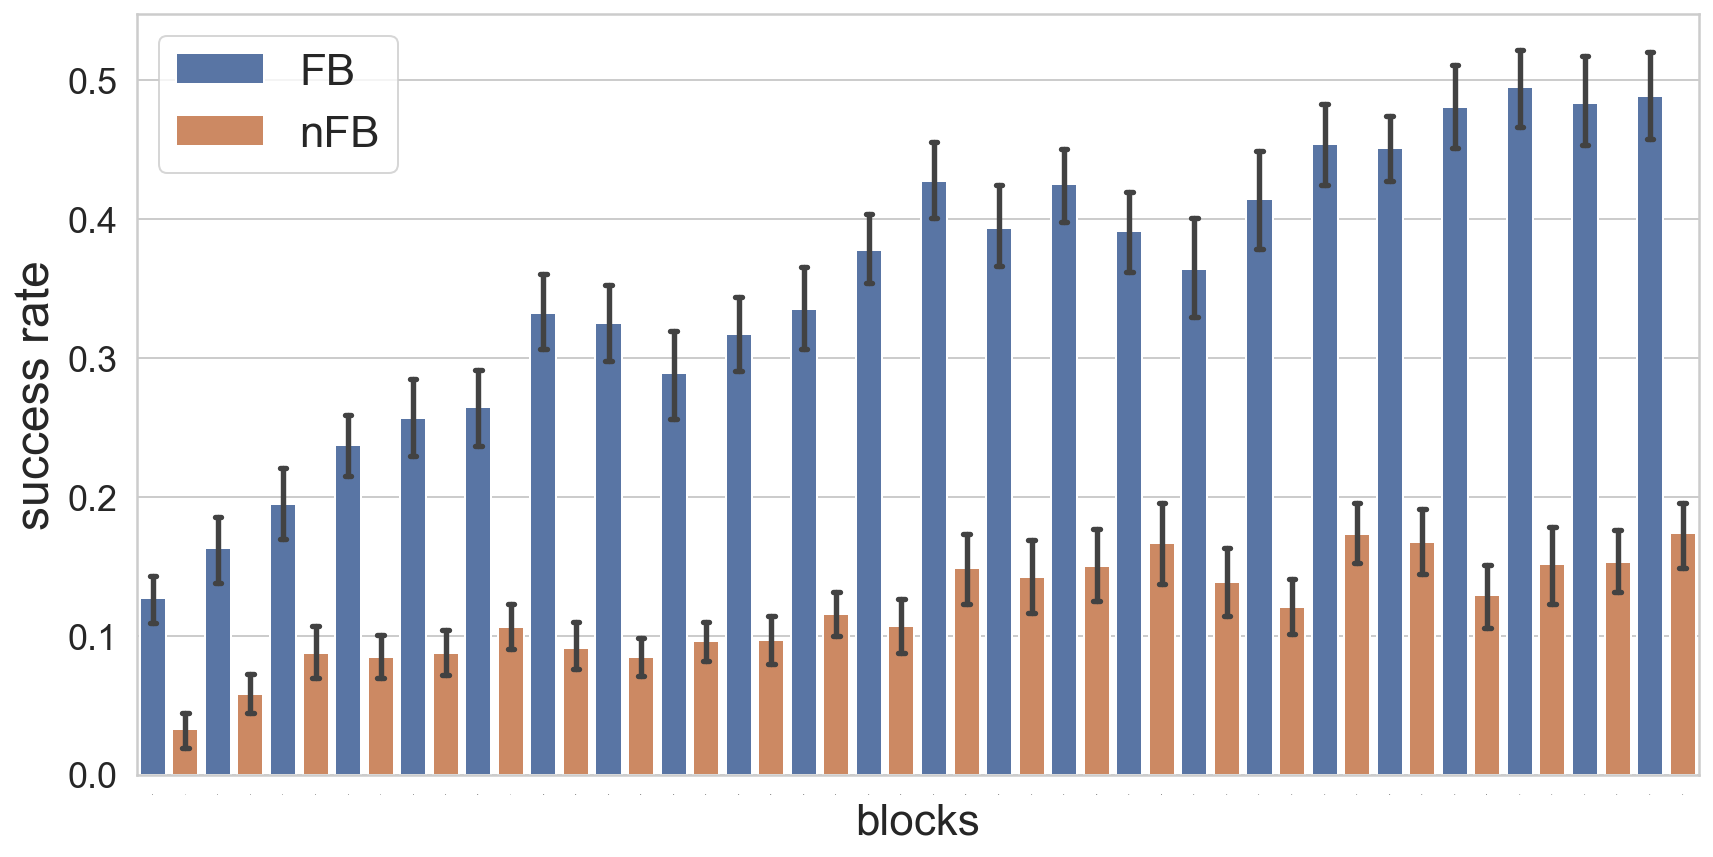

In [28]:
sns.set(style="whitegrid")

ax = plt.figure(figsize=(14, 7))
sns.barplot(x='variable', y='value', data=dk, hue='hue', ci=100*sigma_1, capsize=.2, dodge=False)
plt.ylabel('success rate', size=24)
plt.xlabel('blocks', size=22)
plt.legend(fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=0)
# ax.legend(fontsize=22)

# ax.savefig(join(output_dir,today+'.behav.group.png'), dpi=300)